## Unbanked Paper

## EDA + Model Train Testing

### Install / import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import ks_2samp
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Utility helpers

In [2]:
TODAY = pd.Timestamp("2025-01-01")        # keep fixed for reproducibility

def prep_dates(df, col):
    return (TODAY - pd.to_datetime(df[col], errors="coerce")).dt.days / 365.25

def parse_subscription_list(s):
    if pd.isna(s):
        return 0
    try:
        return len(eval(s))
    except Exception:
        return 0

def ks_stat(y_true, y_prob):
    return ks_2samp(y_prob[y_true == 1], y_prob[y_true == 0]).statistic

def cv_evaluate(clf, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    metrics = {"AUC":[], "F1":[], "Precision":[], "Recall":[], "KS":[]}

    for tr, te in skf.split(X, y):
        clf.fit(X.iloc[tr], y.iloc[tr])
        proba = clf.predict_proba(X.iloc[te])[:, 1]
        pred  = (proba >= 0.5).astype(int)

        metrics["AUC"].append(roc_auc_score(y.iloc[te], proba))
        metrics["F1"].append(f1_score(y.iloc[te], pred))
        metrics["Precision"].append(precision_score(y.iloc[te], pred))
        metrics["Recall"].append(recall_score(y.iloc[te], pred))
        metrics["KS"].append(ks_stat(y.iloc[te], proba))

    return {k: np.mean(v) for k, v in metrics.items()}


###  Load synthetic data & light feature engineering

In [3]:
import pandas as pd
import ast

df = pd.read_csv(r"C:\Users\yineh\OneDrive\Masaüstü\istanbul_synthetic_data_v22.csv")

# Convert purchase dates as before…
for c in ["phone_purchase_date", "car_purchase_date"]:
    df[c] = prep_dates(df, c)

# 2024 Q1 Istanbul subscription fees (TL) — all ints!
subscription_costs = {
    "Netflix": 230,
    "Spotify": 60,
    "Disney+": 165,
    "Amazon Prime": 39,       # now an int
    "YouTube Premium": 80,
    "Apple Music": 40,
    "Gym": 1207
}

def calc_subscription_cost(s):
    if pd.isna(s) or not s.strip():
        return 0
    try:
        subs = ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return 0
    subs = [item for item in subs if item in subscription_costs]
    return sum(subscription_costs[item] for item in subs)


# Apply to DataFrame
df["monthly_subscription_cost"] = df["monthly_subscriptions"].apply(calc_subscription_cost).astype(int)

# 
# Sanity check
counts = df["delinquency_FL"].value_counts().sort_index()
print(counts)

# Or, explicitly:
num_zero = (df["delinquency_FL"] == 0).sum()
num_one  = (df["delinquency_FL"] == 1).sum()
print(f"0’s: {num_zero}\n1’s: {num_one}")

delinquency_FL
0    75809
1    24191
Name: count, dtype: int64
0’s: 75809
1’s: 24191


###  Define feature groups

In [4]:
demographic = [
    "age", "education", "employment_status", "job",
    "monthly_income", "home_district", "owns_home"
]

alternative = [
    "phone_model", "phone_purchase_date",
    "owns_car", "car_brand", "car_purchase_date",
    "owns_credit_card", "monthly_subscription_cost",
    "online_shopping_frequency", "social_media_active"
]

full_features = demographic + alternative
target = "delinquency_FL"


### Column splitter + pipeline builder

In [5]:
def split_cols(df, cols):
    cat, num = [], []
    for c in cols:
        if df[c].dtype in ("object", "bool") or str(df[c].dtype).startswith("category"):
            cat.append(c)
        else:
            num.append(c)
    return cat, num

def make_pipeline(model, features):
    cat_cols, num_cols = split_cols(df, features)
    pre = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])
    return Pipeline([("pre", pre), ("clf", model)])

### Correlation Matrix

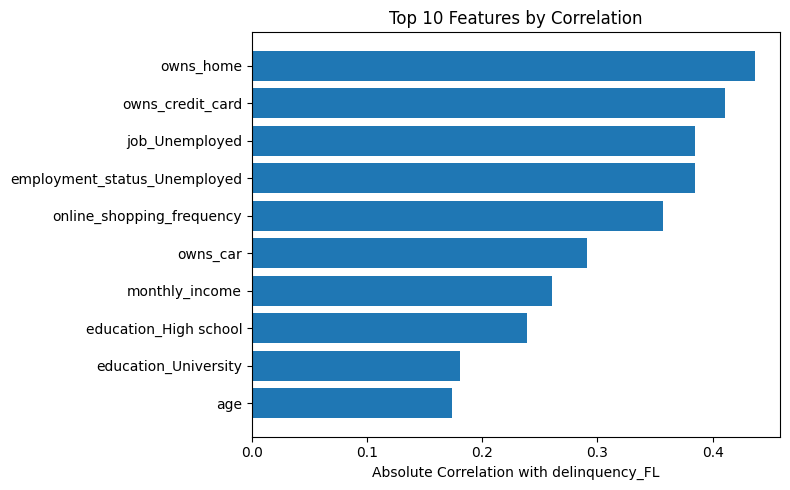

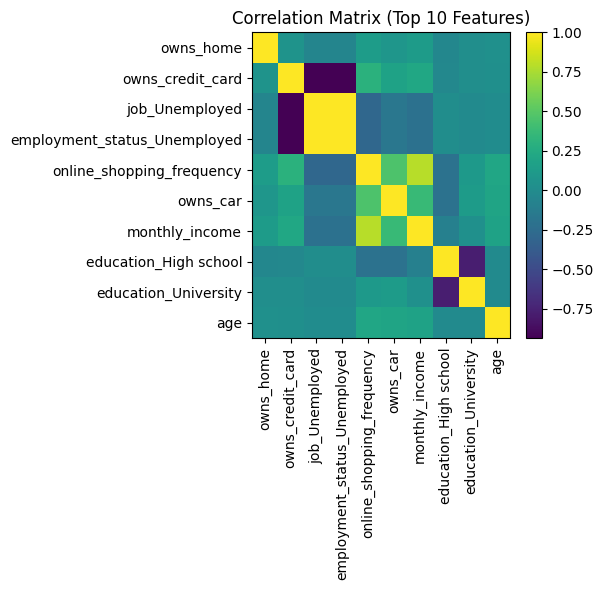

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) One-hot encode and build correlation matrix
features = full_features + [target]
df_corr = pd.get_dummies(df[features], drop_first=True)
corr_matrix = df_corr.corr()

# 2) Identify top 10 features most correlated with target
target_corr = corr_matrix[target].abs().sort_values(ascending=False)
top_features = target_corr.index[1:11]  # skip the target itself

# 3) Bar chart of top correlations
plt.figure(figsize=(8, 5))
plt.barh(range(len(top_features)), target_corr[top_features])
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Absolute Correlation with delinquency_FL")
plt.title("Top 10 Features by Correlation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4) Heatmap of correlations among those top 10 features
sub_corr = corr_matrix.loc[top_features, top_features]
plt.figure(figsize=(6, 6))
plt.imshow(sub_corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.yticks(range(len(top_features)), top_features)
plt.title("Correlation Matrix (Top 10 Features)")
plt.tight_layout()
plt.show()


### Instantiate the Models

In [7]:
from sklearn.preprocessing import StandardScaler

cat_cols, num_cols = split_cols(df, demographic)


# 2) build the preprocessor for LogisticRegression (Model-D)
logistic_pre = ColumnTransformer([
    ("num", StandardScaler(),                         num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"),   cat_cols)
], sparse_threshold=0)  # force dense output so StandardScaler can center


def make_pipeline(model, features):
    # If the model is already a Pipeline (i.e. Model-D), trust it's fully defined
    if isinstance(model, Pipeline):
        return model

    # Otherwise build the usual preprocessor + model wrapper
    cat_cols, num_cols = split_cols(df, features)
    pre = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], sparse_threshold=0)
    return Pipeline([("pre", pre), ("clf", model)])



# 2) Model specs with early stopping & reg params
model_specs = {
    "Model-A": (
        CatBoostClassifier(
            iterations=1000,
            depth=3,
            learning_rate=0.3,
            task_type="GPU",
            devices="0",
            loss_function="Logloss",
            auto_class_weights="Balanced",   # handle imbalance
            od_type="Iter",                  # overfitting detector
            bootstrap_type="Bernoulli",
            od_wait=100,                     # rounds with no improv
            subsample=0.8,                   # 80% row subsample
            l2_leaf_reg=3,                   # L2 regularization
            verbose=False,
            random_state=42,
            allow_writing_files=False
        ),
        demographic
    ),
    "Model-B": (
        CatBoostClassifier(
            iterations=1000,
            depth=3,
            learning_rate=0.3,
            task_type="GPU",
            devices="0",
            loss_function="Logloss",
            auto_class_weights="Balanced",
            od_type="Iter",
            od_wait=100,
            bootstrap_type="Bernoulli",
            subsample=0.8,
            l2_leaf_reg=3,
            verbose=False,
            random_state=42,
            allow_writing_files=False
        ),
        full_features
    ),
    "Model-C": (
        LGBMClassifier(
            n_estimators=1000,
            max_depth=3,
            learning_rate=0.3,
            device="gpu",
            class_weight="balanced",
            force_row_wise=True,
            random_state=42,
            n_jobs=-1,
            verbosity=-1,
        ),
        full_features
    ),
    "Model-D": (
        Pipeline([
            ("pre", logistic_pre),
            ("clf", LogisticRegression(
                solver="lbfgs", max_iter=1000, class_weight="balanced", tol=1e-4
            ))
        ]),
        full_features
    ),
    "Model-E": (
        XGBClassifier(
            n_estimators=1000,
            max_depth=3,
            learning_rate=0.3,
            tree_method="hist",
            predictor="gpu_predictor",
            gpu_id=0,
            scale_pos_weight=int(88116/11884),  # rebalance classes
            subsample=0.8,                      # row subsample
            colsample_bytree=0.8,               # feature subsample
            reg_alpha=0.1,                      # L1 reg
            reg_lambda=0.1,                     # L2 reg
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=100,
            
        ),
        full_features
    ),
}


pipe_C = make_pipeline(model_specs["Model-C"][0], full_features)
pipe_E = make_pipeline(model_specs["Model-E"][0], full_features)

model_specs["Model-F"] = ("ensemble", full_features)



### Cross‑validate & display summary table

In [8]:
import pandas as pd
import numpy as np
import time
import copy
import joblib

from tqdm.auto             import tqdm
from scipy.stats           import ks_2samp
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics      import roc_auc_score, f1_score, precision_score, recall_score

import lightgbm as lgb  # for callbacks

def ks_stat(y_true, y_prob):
    return ks_2samp(y_prob[y_true == 1], y_prob[y_true == 0]).statistic

# A tiny wrapper class for your “Model-F” soft‐voting ensemble
class EnsembleModel:
    def __init__(self, pipe1, pipe2, w1=0.5):
        # deep‐copy to freeze them at last‐fold state
        self.pipe1 = copy.deepcopy(pipe1)
        self.pipe2 = copy.deepcopy(pipe2)
        self.w1    = w1

    def predict_proba(self, X):
        p1 = self.pipe1.predict_proba(X)[:,1]
        p2 = self.pipe2.predict_proba(X)[:,1]
        p  = self.w1 * p1 + (1 - self.w1) * p2
        # return the 2-col shape [P(0), P(1)]
        return np.vstack([1-p, p]).T

# STORAGE for the last‐fold–fitted pipelines
last_pipes = {}

# METRICS containers
results     = {}
train_times = {}
y           = df[target]
skf         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, (estimator, feats) in model_specs.items():
    last_pipes[name] = None
    t0 = time.time()
    fold_metrics = {m: [] for m in ("AUC","F1","Precision","Recall","KS")}

    for train_idx, test_idx in tqdm(
        skf.split(df, y), total=5, desc=f"{name} CV"
    ):
        X_tr, X_te = df.iloc[train_idx][feats], df.iloc[test_idx][feats]
        y_tr, y_te = y.iloc[train_idx],          y.iloc[test_idx]

        # — Model-C (LightGBM) —
        if name == "Model-C":
            pre      = pipe_C.named_steps["pre"]
            X_tr_enc = pre.fit_transform(X_tr)
            X_te_enc = pre.transform(X_te)
            clf      = pipe_C.named_steps["clf"]
            clf.fit(
                X_tr_enc, y_tr,
                eval_set=[(X_te_enc, y_te)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=0)
                ],
            )
            prob = clf.predict_proba(X_te_enc)[:,1]
            # stash a deep‐copy of the entire pipeline:
            last_pipes[name] = copy.deepcopy(pipe_C)

        # — Model-E (XGBoost) —
        elif name == "Model-E":
            pre      = pipe_E.named_steps["pre"]
            X_tr_enc = pre.fit_transform(X_tr)
            X_te_enc = pre.transform(X_te)
            clf      = pipe_E.named_steps["clf"]
            clf.fit(
                X_tr_enc, y_tr,
                eval_set=[(X_te_enc, y_te)],
                verbose=False
            )
            prob = clf.predict_proba(X_te_enc)[:,1]
            last_pipes[name] = copy.deepcopy(pipe_E)

        # — Model-F (Ensemble of C+E) —
        elif name == "Model-F":
            # retrain LightGBM half
            pre  = pipe_C.named_steps["pre"]
            Xc_tr, Xc_te = pre.fit_transform(X_tr), pre.transform(X_te)
            lgbm = pipe_C.named_steps["clf"]
            lgbm.fit(
                Xc_tr, y_tr,
                eval_set=[(Xc_te, y_te)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=100),
                    lgb.log_evaluation(period=0)
                ],
            )
            p1 = lgbm.predict_proba(Xc_te)[:,1]

            # retrain XGBoost half
            pre  = pipe_E.named_steps["pre"]
            Xx_tr, Xx_te = pre.fit_transform(X_tr), pre.transform(X_te)
            xgb  = pipe_E.named_steps["clf"]
            xgb.fit(
                Xx_tr, y_tr,
                eval_set=[(Xx_te, y_te)],
                verbose=False
            )
            p2 = xgb.predict_proba(Xx_te)[:,1]

            prob = 0.5 * p1 + 0.5 * p2
            # build & store the ensemble model
            last_pipes[name] = EnsembleModel(pipe_C, pipe_E, w1=0.5)

        # — All others (A, B, D) —
        else:
            pipe = make_pipeline(estimator, feats)
            pipe.fit(X_tr, y_tr)
            prob = pipe.predict_proba(X_te)[:,1]
            last_pipes[name] = pipe

        # collect metrics
        pred = (prob >= 0.5).astype(int)
        fold_metrics["AUC"].append(       roc_auc_score(y_te, prob))
        fold_metrics["F1"].append(        f1_score(      y_te, pred))
        fold_metrics["Precision"].append( precision_score(y_te, pred))
        fold_metrics["Recall"].append(    recall_score(  y_te, pred))
        fold_metrics["KS"].append(        ks_stat(       y_te, prob))

    results[name]     = {m: np.mean(v) for m,v in fold_metrics.items()}
    train_times[name] = round(time.time() - t0, 2)

# summarize CV
metrics_df = pd.DataFrame(results).T.round(4)
metrics_df["Train Time (s)"] = pd.Series(train_times)
print(metrics_df)

# pick best & save the **already‐fitted** pipeline
best_name = metrics_df["AUC"].idxmax()
best_pipe = last_pipes[best_name]

for name, fitted_pipe in last_pipes.items():
    # skip any models that never got set (shouldn’t happen if your loop covered A–F)
    if fitted_pipe is None:
        continue
    joblib.dump(fitted_pipe, f"{name}_pipeline.joblib")
    print(f"→ Saved {name} pipeline to {name}_pipeline.joblib")


Model-A CV:   0%|          | 0/5 [00:00<?, ?it/s]

Model-B CV:   0%|          | 0/5 [00:00<?, ?it/s]

Model-C CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.180254


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	valid_0's binary_logloss: 0.17531


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.17714


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.178285


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's binary_logloss: 0.171526


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Model-D CV:   0%|          | 0/5 [00:00<?, ?it/s]

Model-E CV:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Program Files\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:05:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  self.starting_round = model.num_boosted_rounds()
c:\Program Files\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:05:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Program Files\Python311\Lib\site-packages\xgboost\core.py:729: UserWarning: [00:05:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that mat

Model-F CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.180254


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:05:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	valid_0's binary_logloss: 0.17531


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:06:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.17714


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:06:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.178285


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:06:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's binary_logloss: 0.171526


c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:06:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


            AUC      F1  Precision  Recall      KS  Train Time (s)
Model-A  0.9498  0.8445     0.7862  0.9121  0.8343           24.82
Model-B  0.9611  0.9067     0.8845  0.9301  0.8920           29.07
Model-C  0.9620  0.9087     0.8865  0.9320  0.8943            5.92
Model-D  0.9324  0.7817     0.6979  0.8883  0.7666            1.99
Model-E  0.9606  0.8933     0.8567  0.9332  0.8893           12.24
Model-F  0.9615  0.9061     0.8804  0.9333  0.8941           17.57
→ Saved Model-A pipeline to Model-A_pipeline.joblib
→ Saved Model-B pipeline to Model-B_pipeline.joblib
→ Saved Model-C pipeline to Model-C_pipeline.joblib
→ Saved Model-D pipeline to Model-D_pipeline.joblib
→ Saved Model-E pipeline to Model-E_pipeline.joblib
→ Saved Model-F pipeline to Model-F_pipeline.joblib


### Visualization

c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== Raw Metrics ===

AUCs:
  Model-A: 0.967185
  Model-B: 0.981391
  Model-C: 0.979844
  Model-D: 0.932617
  Model-E: 0.985010
  Model-F: 0.984770

Average Precision (AP):
  Model-A: 0.916416
  Model-B: 0.953649
  Model-C: 0.954343
  Model-D: 0.843088
  Model-E: 0.959446
  Model-F: 0.960453


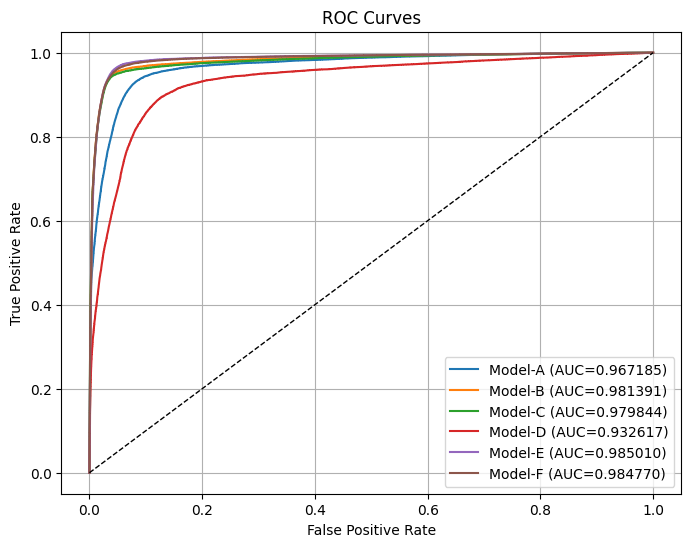

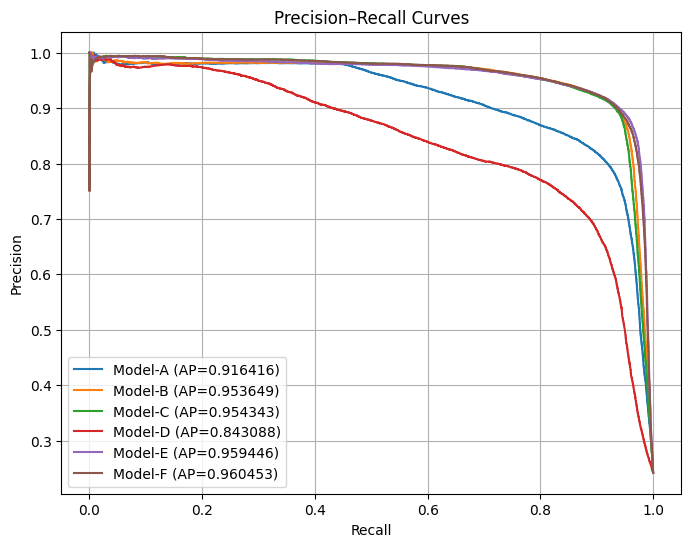

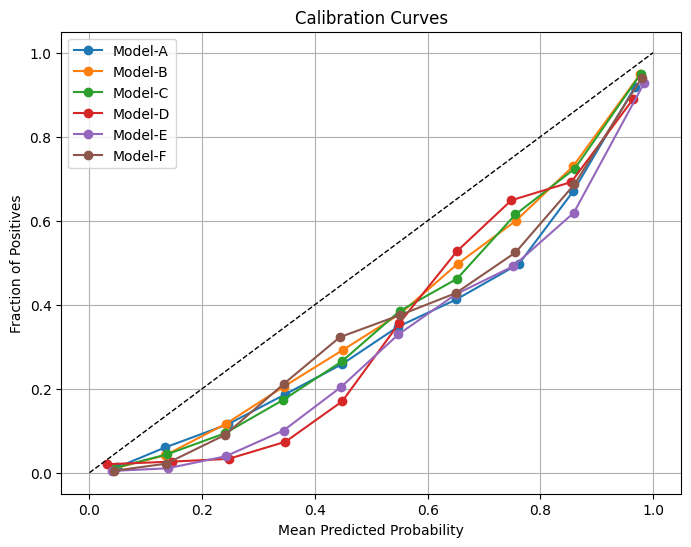

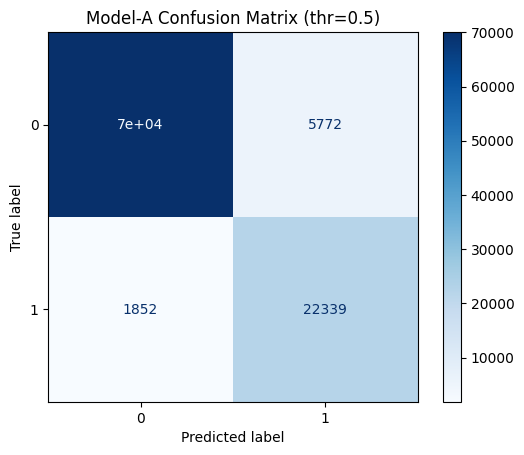

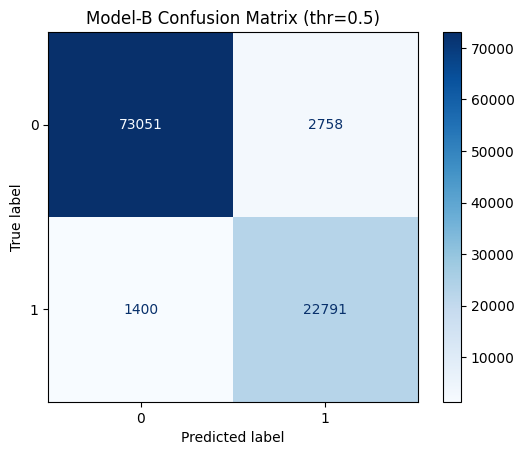

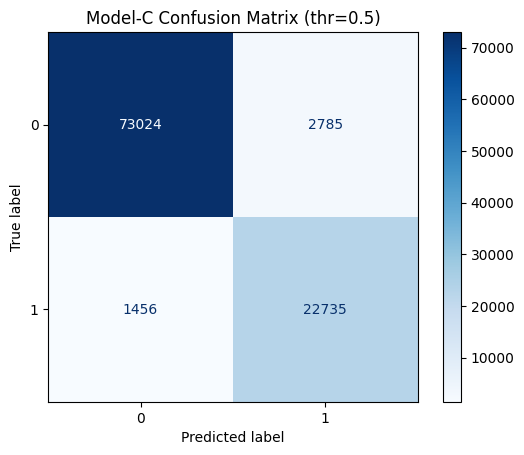

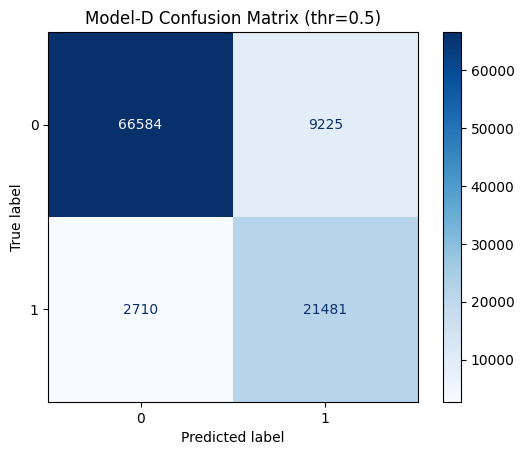

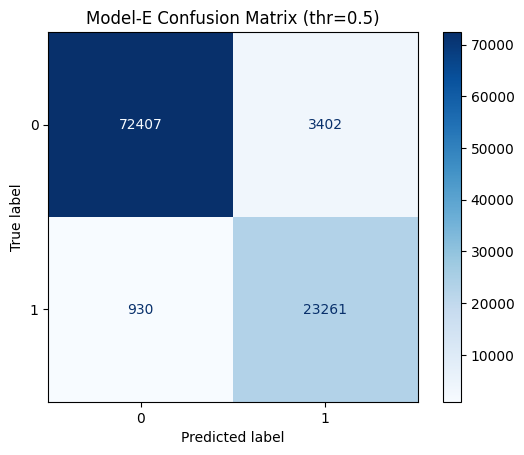

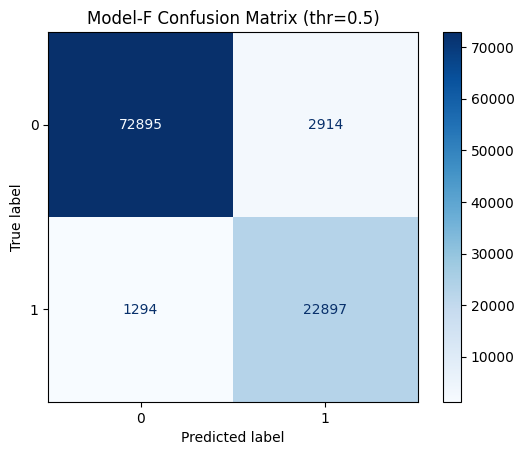

In [9]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

X = df[full_features]
y = df[target]

model_names = ["Model-A","Model-B","Model-C","Model-D","Model-E","Model-F"]
pipelines   = {n: joblib.load(f"{n}_pipeline.joblib") for n in model_names}

# 2) Get predicted probabilities
probs = {n: pl.predict_proba(X)[:,1] for n, pl in pipelines.items()}

# 3) Compute raw metrics
raw_aucs = {}
raw_aps  = {}
for n, p in probs.items():
    fpr, tpr, _  = roc_curve(y, p)
    raw_aucs[n]  = auc(fpr, tpr)
    raw_aps[n]   = average_precision_score(y, p)

# 4) Print raw metrics
print("=== Raw Metrics ===\n")
print("AUCs:")
for n, val in raw_aucs.items():
    print(f"  {n}: {val:.6f}")
print("\nAverage Precision (AP):")
for n, val in raw_aps.items():
    print(f"  {n}: {val:.6f}")

# 5) ROC curves
plt.figure(figsize=(8,6))
for n, p in probs.items():
    fpr, tpr, _ = roc_curve(y, p)
    plt.plot(fpr, tpr, label=f"{n} (AUC={raw_aucs[n]:.6f})")
plt.plot([0,1],[0,1],"k--", linewidth=1)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6) Precision–Recall curves
plt.figure(figsize=(8,6))
for n, p in probs.items():
    prec, rec, _ = precision_recall_curve(y, p)
    plt.plot(rec, prec, label=f"{n} (AP={raw_aps[n]:.6f})")
plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 7) Calibration plots
plt.figure(figsize=(8,6))
for n, p in probs.items():
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=10)
    plt.plot(mean_pred, frac_pos, "o-", label=n)
plt.plot([0,1],[0,1],"k--", linewidth=1)
plt.title("Calibration Curves")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# 8) Confusion matrices @ 0.5 threshold
for n, p in probs.items():
    pred = (p >= 0.5).astype(int)
    cm   = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap="Blues")
    plt.title(f"{n} Confusion Matrix (thr=0.5)")
    plt.show()


### (Optionally) inspect top‑risk applicants

In [36]:
df[["id", f"{best_name}_prob"]].sort_values(by=f"{best_name}_prob", ascending=False).head(10)


,id,Model-B_prob
15123,15124,0.996365
76911,76912,0.996105
8017,8018,0.995998
59051,59052,0.995978
88596,88597,0.995972
67506,67507,0.995891
18733,18734,0.995732
33667,33668,0.995710
22172,22173,0.995697
12501,12502,0.995687
